# Natural Language Classification Project
## Ella Steen and Sharon Patta


Our goal in this project is to take a symptom location from a patient and classify which category of health their symptom is best related to: cardiac, gastroenterological, dermatological, musculoskeletal, or respiratory. This can be helpful for recommending what sort of physician a person should consult.

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.pyplot import figure
import string
import numpy as np
from PIL import Image
import seaborn as sns
import string
import re
from nltk.classify import NaiveBayesClassifier, accuracy
import random
from sklearn.utils import shuffle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading and Cleaning the Data

The data come from different sources. In the cells below, we clean and prepare the data and standardize it into one dataset. Sources:
* https://figshare.com/s/d83162fad67407081b32/articles/16550013
* https://www.kaggle.com/datasets/paultimothymooney/medical-speech-transcription-and-intent

In [3]:
recording_transcriptions = pd.read_csv('/content/drive/My Drive/Colab Notebooks/overview-of-recordings.csv')

recording_transcriptions

,audio_clipping,audio_clipping:confidence,background_noise_audible,background_noise_audible:confidence,overall_quality_of_the_audio,quiet_speaker,quiet_speaker:confidence,speaker_id,file_download,file_name,phrase,prompt,writer_id
0,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,43453425,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,21665495
1,light_clipping,0.6803,no_noise,0.6803,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking...,Hair falling out,44088126
2,no_clipping,1.0000,no_noise,0.6655,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_53187202.wav,there is too much pain when i move my arm,Heart hurts,44292353
3,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,31349958,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen a...,Infected wound,43755034
4,no_clipping,1.0000,no_noise,1.0000,4.67,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,21665495
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6656,no_clipping,1.0000,no_noise,0.6076,3.80,audible_speaker,1.0,14353703,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_14353703_45949288.wav,I feel a burning sensation in my guts about 2 ...,Stomach ache,40925305
6657,no_clipping,1.0000,no_noise,0.7829,3.80,audible_speaker,1.0,15004831,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_15004831_26452554.wav,I have a split on my thumb that will not heal.,Open wound,43755034
6658,no_clipping,1.0000,no_noise,0.6061,3.80,audible_speaker,1.0,15004831,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_15004831_64958100.wav,I feel a lot of pain in the joints.,Joint pain,43772689
6659,no_clipping,1.0000,no_noise,0.8215,3.80,audible_speaker,1.0,15830408,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_15830408_92962528.wav,The area around my heart doesn't feel good.,Heart hurts,44292353


In [4]:
recording_transcriptions['prompt'].unique()

medical_categories = ['Heart hurts', 'Foot ache', 'Shoulder pain', 'Injury from sports', 'Skin issue', 'Stomach ache', 'Knee pain',
       'Joint pain', 'Hard to breath', 'Head ache', 'Back pain', 'Acne', 'Muscle pain', 'Neck pain', 'Ear ache']

recording_transcriptions = recording_transcriptions[recording_transcriptions['prompt'].isin(medical_categories)]

In [5]:
recording_transcriptions = recording_transcriptions[['phrase', 'prompt']]

In [6]:
recording_transcriptions['prompt'] = recording_transcriptions['prompt'].replace(medical_categories, ['cardiac', 'musculoskeletal', 'musculoskeletal',
                                                                 'musculoskeletal', 'dermatological', 'gastroenterological',
                                                                 'musculoskeletal', 'musculoskeletal', 'respiratory',
                                                                 'musculoskeletal', 'musculoskeletal', 'dermatological',
                                                                 'musculoskeletal', 'musculoskeletal', 'musculoskeletal'])

In [7]:
recording_transcriptions = recording_transcriptions.rename(columns={'phrase':'sentence', 'prompt':'label'})

recording_transcriptions = recording_transcriptions.reset_index(drop=True)
recording_transcriptions

,sentence,label
0,there is too much pain when i move my arm,cardiac
1,i have muscle pain that my back\nI Have Muscle...,musculoskeletal
2,I have muscle pain in my left leg,musculoskeletal
3,I have cut my finger because of playing footba...,musculoskeletal
4,I have acne in my face and other problems in m...,dermatological
...,...,...
4073,I have a ear ache when I go to the pool,musculoskeletal
4074,I feel a burning sensation in my guts about 2 ...,gastroenterological
4075,I feel a lot of pain in the joints.,musculoskeletal
4076,The area around my heart doesn't feel good.,cardiac


This function pulls the text files into dataframes sentence by sentence, and concatenates all the dataframes at the end. The two columns of the final dataframe are 'sentence' and 'label'. This function also removes the sentences said by the doctors (as they do not contain symptom keywords), makes all text lowercase, and removes punctuation.

In [8]:
filepath_dict = {'cardiac':   '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/CAR0001.txt',
                 'cardiac': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/CAR0002.txt',
                 'cardiac':   '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/CAR0003.txt',
                 'cardiac':   '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/CAR0004.txt',
                 'cardiac':   '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/CAR0005.txt',
                 'dermatological': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/DER0001.txt',
                 'gastroenterological':   '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/GAS0001.txt',
                 'gastroenterological':   '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/GAS0002.txt',
                 'gastroenterological':   '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/GAS0003.txt',
                 'gastroenterological':   '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/GAS0004.txt',
                 'gastroenterological':   '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/GAS0005.txt',
                 'gastroenterological':   '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/GAS0007.txt',
                 'musculoskeletal': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/MSK0001.txt',
                 'musculoskeletal': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/MSK0002.txt',
                 'musculoskeletal': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/MSK0003.txt',
                 'musculoskeletal': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/MSK0004.txt',
                 'musculoskeletal': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/MSK0005.txt',
                 'respiratory': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/RES0001.txt',
                 'respiratory': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/RES0002.txt',
                 'respiratory': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/RES0003.txt',
                 'respiratory': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/RES0004.txt',
                 'respiratory': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/RES0005.txt',
                 'respiratory': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/RES0006.txt',
                 'respiratory': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/RES0007.txt',
                 'respiratory': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/RES0008.txt',
                 'respiratory': '/content/drive/My Drive/Colab Notebooks/Clean Transcripts/RES0009.txt'}

In [35]:
df_list = []

nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
new_stopwords = ['p:'] # The patient lines in some of the transcripts start with P:, so we'll want to remove those from the clean data
stop_words = stop_words.union(new_stopwords)

# Adding all of the text from patient/doctor conversations into dataframes with sentences and labels
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['label'] = source
    # Filtering rows to only include patient lines
    df = df[df['sentence'].str.startswith('P:')]
    df_list.append(df)
    
df = pd.concat(df_list)
df = pd.concat([df, recording_transcriptions])
df['sentence'] = df['sentence'].apply(
        lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)])
    )
df['sentence'] = df['sentence'].str.translate(str.maketrans('', '', string.punctuation)) #remove punctuation

df = df.reset_index(drop=True)
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,sentence,label
0,Yeah chest pain coming last couple weeks now,cardiac
1,Um yeah Im Im feeling chest discomfort sort le...,cardiac
2,No really feel anywhere else Yeah feel one spo...,cardiac
3,feels pretty sharp,cardiac
4,comes goes would say might last um 2030 minute...,cardiac
...,...,...
4281,ear ache go pool,musculoskeletal
4282,feel burning sensation guts 2 hours meal,gastroenterological
4283,feel lot pain joints,musculoskeletal
4284,area around heart feel good,cardiac


In [36]:
#df['sentence'] = df['sentence'].str.replace('\d+', '')

df

,sentence,label
0,Yeah chest pain coming last couple weeks now,cardiac
1,Um yeah Im Im feeling chest discomfort sort le...,cardiac
2,No really feel anywhere else Yeah feel one spo...,cardiac
3,feels pretty sharp,cardiac
4,comes goes would say might last um 2030 minute...,cardiac
...,...,...
4281,ear ache go pool,musculoskeletal
4282,feel burning sensation guts 2 hours meal,gastroenterological
4283,feel lot pain joints,musculoskeletal
4284,area around heart feel good,cardiac


### EDA

Let's take a look at the distribution of samples we have across the five medical categories.

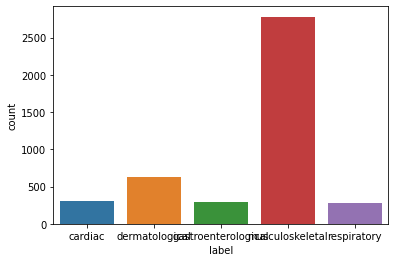

In [37]:
sns.countplot(x='label', data=df)

It appears that there are many more musculoskeletal samples than the others, so we will get rid of some to better the model.

In [38]:
df['label'].value_counts()

musculoskeletal        2780
dermatological          631
cardiac                 306
gastroenterological     294
respiratory             275
Name: label, dtype: int64

We will select a subset of around 300 phrases for muscoloskeletal.

In [39]:
musc_df = df[df['label'] == 'musculoskeletal'].sample(n=300)

musc_df

,sentence,label
3881,cant turn neck left without feeling stabbing pain,musculoskeletal
1121,move shoulder like lightning sent shoulder,musculoskeletal
4041,difficulty moving neck,musculoskeletal
3333,sharp pain calve,musculoskeletal
281,back pain since fell floor,musculoskeletal
...,...,...
1692,Theres swelling neck hurts,musculoskeletal
3078,knee want bend well,musculoskeletal
408,walking pain foot,musculoskeletal
4183,play football muscle pain,musculoskeletal


In [40]:
df = df[df['label'] != 'musculoskeletal']

In [41]:
df = pd.concat([df, musc_df])

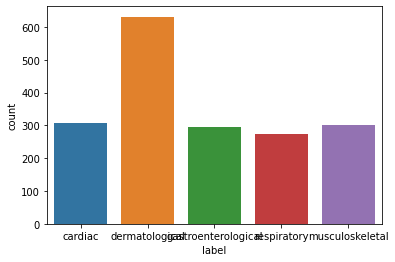

In [42]:
sns.countplot(x='label', data=df)

### Modeling

We will try a few different models based on the Naive Bayes algorithm to classify the features. 

In [43]:
df['sentence']

0            Yeah chest pain coming last couple weeks now
1       Um yeah Im Im feeling chest discomfort sort le...
2       No really feel anywhere else Yeah feel one spo...
3                                      feels pretty sharp
4       comes goes would say might last um 2030 minute...
                              ...                        
1692                           Theres swelling neck hurts
3078                                  knee want bend well
408                                     walking pain foot
4183                            play football muscle pain
1350               feel great pain shoulder joint go away
Name: sentence, Length: 1806, dtype: object

First we need to split the data into training and test sets.

In [53]:
X = df['sentence'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [54]:
X_train

array(['acne face',
       'often get stomach ache eat able pinpoint foods might trigger',
       'Yeah while yeah Im stressed', ..., 'chest hurts go take breath',
       'stomach feels full upset bloating big meals',
       'heart pumping fast Im hard time breath'], dtype=object)

Now we will vectorize the data. This is a necessary step which converts the text data into numerical data before training the model, which can only interpret numbers. This will convert the text into feature vectors based on term frequency.

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()       
tfidf_vect.fit(X_train)               
print("Feature Names :", tfidf_vect.get_feature_names_out())

X_train = tfidf_vect.transform(X_train)
X_test = tfidf_vect.transform(X_test)

Feature Names : ['10' '15' '2030' '45' '60' '70' 'a1c' 'abdomen' 'abdominal' 'able'
 'about' 'abronchial' 'accident' 'accompanied' 'accountant' 'ache' 'aches'
 'aching' 'acne' 'actually' 'adult' 'advil' 'affected' 'afraid' 'ago'
 'agreat' 'ah' 'air' 'all' 'allergies' 'allergy' 'along' 'alot' 'alright'
 'also' 'always' 'amount' 'analysis' 'and' 'ankle' 'annoying' 'another'
 'answer' 'anymore' 'anything' 'anytime' 'anywhere' 'apply' 'arches'
 'area' 'arm' 'arms' 'around' 'aside' 'asthma' 'ate' 'attack' 'aunts'
 'average' 'away' 'awesome' 'awful' 'awhile' 'bacause' 'back' 'backed'
 'bad' 'badly' 'banged' 'bathroom' 'bear' 'beating' 'beer' 'before'
 'belly' 'bend' 'bent' 'best' 'better' 'bicep' 'biceps' 'big' 'bike' 'bit'
 'blackheads' 'bloated' 'bloating' 'blood' 'body' 'bone' 'boneonbone'
 'book' 'bother' 'bothers' 'bottoms' 'bound' 'brain' 'break' 'breaking'
 'breakouts' 'breaks' 'breath' 'breathe' 'breathing' 'breathless' 'broken'
 'burning' 'burns' 'but' 'buttock' 'button' 'cage' 'cal

In [56]:
X_train

<1444x861 sparse matrix of type '<class 'numpy.float64'>'
	with 7696 stored elements in Compressed Sparse Row format>

In [57]:
xtrain_df = pd.DataFrame(X_train.toarray())
xtrain_df.rename_axis('Feature #', axis = 'columns')

Feature #,0,1,2,3,4,5,6,7,8,9,...,851,852,853,854,855,856,857,858,859,860
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.36986,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.622142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we will train each model and have each make predictions on the test set, then measure their prediction accuracy. The first is a Gaussian Naive Bayes model, which is a classification algorithm that applies Bayes' theorem with an assumption of independence between terms and a normal distribution.

In [58]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

#fit the model to the training data
gnb.fit(X_train.toarray(), y_train)

# making predictions on the test set
y_pred = gnb.predict(X_test.toarray())
y_pred

array(['gastroenterological', 'dermatological', 'dermatological',
       'dermatological', 'dermatological', 'cardiac', 'cardiac',
       'musculoskeletal', 'musculoskeletal', 'dermatological',
       'respiratory', 'dermatological', 'gastroenterological',
       'gastroenterological', 'respiratory', 'respiratory',
       'gastroenterological', 'respiratory', 'gastroenterological',
       'respiratory', 'cardiac', 'gastroenterological',
       'gastroenterological', 'dermatological', 'gastroenterological',
       'dermatological', 'musculoskeletal', 'cardiac', 'cardiac',
       'dermatological', 'cardiac', 'gastroenterological',
       'gastroenterological', 'gastroenterological', 'dermatological',
       'gastroenterological', 'dermatological', 'dermatological',
       'cardiac', 'musculoskeletal', 'musculoskeletal',
       'gastroenterological', 'respiratory', 'musculoskeletal',
       'dermatological', 'gastroenterological', 'respiratory',
       'gastroenterological', 'cardiac', 'g

In [59]:
some_data = X_train[:7].toarray()
some_labels = y_train[:7]

print("Predictions:", gnb.predict(some_data))
print("Labels: \t", list(some_labels))

Predictions: ['dermatological' 'gastroenterological' 'dermatological' 'respiratory'
 'dermatological' 'gastroenterological' 'dermatological']
Labels: 	 ['dermatological', 'gastroenterological', 'dermatological', 'respiratory', 'dermatological', 'gastroenterological', 'dermatological']


In [60]:
from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Gaussian Naive Bayes model accuracy(in %): 93.0939226519337


Next is a Bernoulli Naive Bayes model. This type of classifier is best for binary data, so it likely won't achieve as high an accuracy score as the Gaussian model did.

In [61]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

#fit the model to the training data
bnb.fit(X_train.toarray(), y_train)
  
# making predictions on the test set
bnb_y_pred = bnb.predict(X_test.toarray())
bnb_y_pred

array(['gastroenterological', 'dermatological', 'dermatological',
       'dermatological', 'dermatological', 'cardiac', 'cardiac',
       'musculoskeletal', 'musculoskeletal', 'dermatological',
       'respiratory', 'dermatological', 'gastroenterological',
       'gastroenterological', 'respiratory', 'musculoskeletal',
       'gastroenterological', 'respiratory', 'gastroenterological',
       'respiratory', 'cardiac', 'gastroenterological',
       'gastroenterological', 'dermatological', 'gastroenterological',
       'dermatological', 'musculoskeletal', 'cardiac', 'cardiac',
       'dermatological', 'cardiac', 'gastroenterological',
       'gastroenterological', 'gastroenterological', 'dermatological',
       'gastroenterological', 'dermatological', 'dermatological',
       'cardiac', 'musculoskeletal', 'musculoskeletal',
       'gastroenterological', 'respiratory', 'musculoskeletal',
       'dermatological', 'gastroenterological', 'respiratory',
       'gastroenterological', 'cardiac'

In [62]:
print("Bernoulli Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, bnb_y_pred)*100)

Bernoulli Naive Bayes model accuracy(in %): 94.1988950276243


Finally we will try Multinomail Naive Bayes, which is again better suited for text classification.

In [63]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

#fit the model to the training data
mnb.fit(X_train.toarray(), y_train)
  
# making predictions on the test set
mnb_y_pred = mnb.predict(X_test.toarray())
mnb_y_pred

array(['gastroenterological', 'dermatological', 'dermatological',
       'dermatological', 'dermatological', 'cardiac', 'cardiac',
       'gastroenterological', 'musculoskeletal', 'dermatological',
       'respiratory', 'dermatological', 'gastroenterological',
       'gastroenterological', 'respiratory', 'musculoskeletal',
       'gastroenterological', 'respiratory', 'gastroenterological',
       'respiratory', 'cardiac', 'gastroenterological',
       'gastroenterological', 'dermatological', 'gastroenterological',
       'dermatological', 'musculoskeletal', 'cardiac', 'cardiac',
       'dermatological', 'cardiac', 'gastroenterological',
       'gastroenterological', 'gastroenterological', 'dermatological',
       'gastroenterological', 'dermatological', 'dermatological',
       'cardiac', 'musculoskeletal', 'musculoskeletal',
       'gastroenterological', 'respiratory', 'musculoskeletal',
       'dermatological', 'gastroenterological', 'respiratory',
       'gastroenterological', 'card

In [64]:
some_data = X_train[:7].toarray()
some_labels = y_train[:7]

print("Predictions:", mnb.predict(some_data))
print("Labels: ", list(some_labels))

Predictions: ['dermatological' 'gastroenterological' 'dermatological' 'respiratory'
 'dermatological' 'gastroenterological' 'dermatological']
Labels:  ['dermatological', 'gastroenterological', 'dermatological', 'respiratory', 'dermatological', 'gastroenterological', 'dermatological']


In [65]:
print("Multinomial Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, mnb_y_pred)*100)

Multinomial Naive Bayes model accuracy(in %): 94.47513812154696


The Multinomial Naive Bayes model was able to predict the feature labels with the most accuracy, so we will use the MNB model on our final test.

In [66]:
my_symptom_location = (['foot'])
my_symptom_location = tfidf_vect.transform(my_symptom_location)
my_symptom_category = gnb.predict(my_symptom_location.toarray())

print("You should see a doctor who has a ", my_symptom_category, " specialty")

You should see a doctor who has a  ['musculoskeletal']  specialty


While non-exhaustive, this notebook shows an introduction to text classification with Naive Bayes.